# Object detection

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

Like in other problems, the first step is to build the dataset.

In [2]:
IMAGE_SIZE = 28

class ShapesDataset(Dataset):
    def __init__(self, num_samples, image_size=28):
        self.num_samples = num_samples
        self.image_size = image_size
        self.data, self.labels = self.generate_data(num_samples, image_size)
        
    def generate_data(self, num_samples, image_size):
        data = []
        ys = []
        for i in range(num_samples):
            label = np.random.randint(0, 2)
            image = np.zeros((image_size, image_size), dtype=np.float32)
            if label == 0:
                # Draw a square
                w = np.random.randint(5, image_size // 2)
                h = np.random.randint(5, image_size // 2)
                top_left_x = np.random.randint(0, image_size - w)
                top_left_y = np.random.randint(0, image_size - h)
                image[top_left_y:top_left_y+h, top_left_x:top_left_x+w] = 1.0
                out = (1, top_left_x + w / 2, top_left_y + h / 2, w, h, 0)
            else:
                # Draw a circle
                radius = np.random.randint(5, image_size // 4)
                center_x = np.random.randint(radius, image_size - radius)
                center_y = np.random.randint(radius, image_size - radius)
                y, x = np.ogrid[:image_size, :image_size]
                mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
                image[mask] = 1.0
                out = (1, center_x, center_y, radius * 2, radius * 2, 1)
            data.append(image)
            ys.append(out)

            if i % 2 == 0:
                image = np.random.random((image_size, image_size))
                out = np.random.random(6)
                out[0] = 0
                data.append(image)
                ys.append(out)

        ys = torch.tensor(ys) / torch.Tensor([1, image_size, image_size, image_size, image_size, 1])
        return torch.tensor(data).unsqueeze(1).to(torch.float), ys.to(torch.float)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the dataset and dataloaders
train_dataset = ShapesDataset(num_samples=1000, image_size=IMAGE_SIZE)
test_dataset = ShapesDataset(num_samples=200, image_size=IMAGE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

train_dataset[0][0].shape, train_dataset[0][1].shape

/tmp/ipykernel_64901/1962771495.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ys = torch.tensor(ys) / torch.Tensor([1, image_size, image_size, image_size, image_size, 1])


(torch.Size([1, 28, 28]), torch.Size([6]))

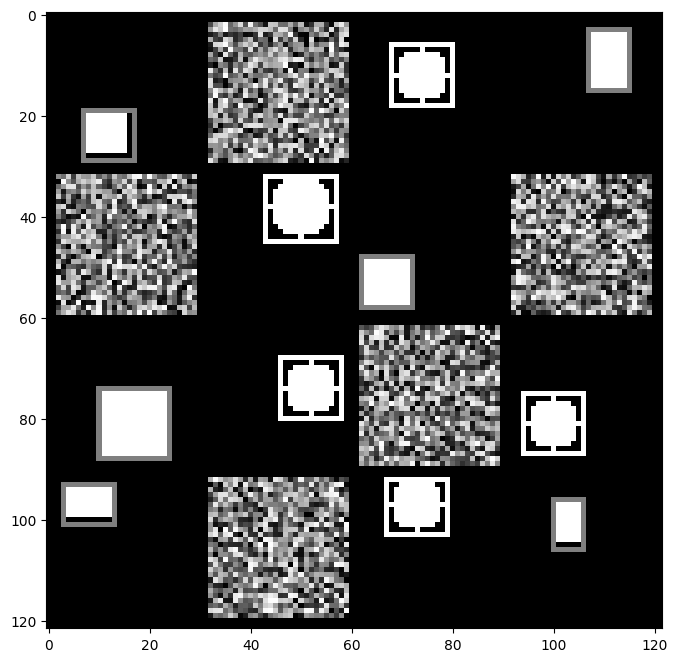

In [3]:
import torchvision.utils as vutils

def draw_rect(fig, rect, color=0.5):
    x, y, w, h = (rect * IMAGE_SIZE).to(torch.int).numpy()
    p1x, p1y = (max(0, x - w // 2 - 1), max(0, y - h // 2 - 1))
    p2x, p2y = (min(IMAGE_SIZE-1, x + w // 2 + 1), min(IMAGE_SIZE-1, y + h // 2 + 1))
    for i in range(p1x, p2x+1):
        fig[0, p1y, i] = color
        fig[0, p2y, i] = color
    for i in range(p1y, p2y+1):
        fig[0, i, p1x] = color
        fig[0, i, p2x] = color

figures, labels = train_dataset[:16]
to_show = []
for f, l in zip(figures, labels):
    fig = f.clone()
    if l[0] > 0.5:
        draw_rect(fig, l[1:5], 1 if l[5] > 0.5 else 0.5)
    to_show.append(fig)

plt.figure(figsize=(8,8))
plt.imshow(np.transpose(vutils.make_grid(to_show, padding=2, normalize=True, nrow=4)
                        ,(1,2,0)))
plt.show()

Lets show how do the size of the tensors changes while moving throw a proposed architecture

In [4]:
h_count = 8

x = next(iter(train_loader))[0]
print("input", x.shape)
for m in [
    nn.Conv2d(in_channels=1, out_channels=h_count, kernel_size=2, padding='same'),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=h_count, out_channels=h_count*2, kernel_size=2, padding='same'),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=h_count*2, out_channels=h_count*4, kernel_size=2, padding='same'),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(start_dim=1),
    nn.Linear(h_count*4*3*3, 7),
]:
    x = m(x)
    print(f"-- {m}")
    print(x.shape)

input torch.Size([10, 1, 28, 28])
-- Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=same)
torch.Size([10, 8, 28, 28])
-- MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([10, 8, 14, 14])
-- Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
torch.Size([10, 16, 14, 14])
-- MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([10, 16, 7, 7])
-- Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
torch.Size([10, 32, 7, 7])
-- MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([10, 32, 3, 3])
-- Flatten(start_dim=1, end_dim=-1)
torch.Size([10, 288])
-- Linear(in_features=288, out_features=7, bias=True)
torch.Size([10, 7])


/home/milton/miniconda3/envs/torch_teach/lib/python3.10/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Create the model

class ObjectDetector(nn.Module):
    def __init__(self, h_count=8):
        super(ObjectDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=h_count, kernel_size=2, padding='same')
        self.conv2 = nn.Conv2d(in_channels=h_count, out_channels=h_count*2, kernel_size=2, padding='same')
        self.conv3 = nn.Conv2d(in_channels=h_count*2, out_channels=h_count*4, kernel_size=2, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(h_count*4*3*3, 7)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        x = self.fc(x)
        return x
    
model = ObjectDetector().to(device)

We need to define a proper loss

In [7]:
class CustomLoss(nn.Module):

    def forward(self, predictions, targets):
        pred_is_object = predictions[:, 0]
        pred_box = predictions[:, 1:5]
        pred_logits = predictions[:, 5:7]

        target_is_object = targets[:, 0]
        target_box = targets[:, 1:5]
        target_class = targets[:, 5].to(torch.long)

        loss = F.mse_loss(pred_is_object, target_is_object)
        is_object = target_is_object == 1
        
        if torch.any(is_object):
            loss += F.mse_loss(pred_box[is_object], target_box[is_object])
            loss += F.cross_entropy(pred_logits[is_object], target_class[is_object])
        return loss


In [8]:
# Loss associated to object
pred = torch.tensor(([1.0, 4, 5, 0, 0, 0.0000, 1.000])).unsqueeze(0)
target = torch.tensor   (([0.0, 1, 2, 0, 0, 1])).unsqueeze(0)
CustomLoss()(pred, target).item(), 1

(1.0, 1)

In [9]:
# Loss associated to box
pred = torch.tensor(([1.0, 0, 0, 0, 0, 0, 100])).unsqueeze(0)
target = torch.tensor((   [1.0, 1, 2, 0, 0, 1])).unsqueeze(0)

CustomLoss()(pred, target).item(), (1**2 + 2**2)/4

(1.25, 1.25)

In [10]:
# Loss associated to classification
pred = torch.tensor(([1.0000, 0, 0, 0, 0, 1.2, 0.5])).unsqueeze(0)
target = torch.tensor(([1.0000, 1, 2, 0, 0, 1])).unsqueeze(0)
CustomLoss()(pred, target).item(), 1.25 - np.log(np.exp(0.5) / (np.exp(1.2) + np.exp(0.5)))

(2.3531861305236816, 2.353186048885458)

In [11]:
# larger batch

pred = torch.tensor(([
    [1.0, 4, 5, 0, 0, 0.0000, 1.000], 
    [1.0, 0, 0, 0, 0, 0, 100]
    ]))
target = torch.tensor(([
    [0.0, 1, 2, 0, 0, 1], 
    [1.0, 1, 2, 0, 0, 1]
    ]))
CustomLoss()(pred, target).item(), (1**2/2) + 1.25

(1.75, 1.75)

In [12]:
# Create the loss function and optimizer
loss_fn = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 30
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % (num_epochs // 10) == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

print("Training complete")

Epoch [1/30], Loss: 0.7271891632676124
Epoch [4/30], Loss: 0.010774809299036861
Epoch [7/30], Loss: 0.007314600797835738
Epoch [10/30], Loss: 0.004580285527044908
Epoch [13/30], Loss: 0.0036897852038964628
Epoch [16/30], Loss: 0.0035440446919528766
Epoch [19/30], Loss: 0.0032741594989784063
Epoch [22/30], Loss: 0.0034584691503550856
Epoch [25/30], Loss: 0.0028302245336817577
Epoch [28/30], Loss: 0.0021394485935161355
Training complete


In [13]:
outputs[:5], labels[:5]

(tensor([[ 0.0093,  0.2307,  0.4322,  0.3166,  0.4626, -4.8782,  4.9010],
         [ 0.0055,  0.1893,  0.4853,  0.2978,  0.5037, -2.4161,  2.4136],
         [ 0.9920,  0.3820,  0.2917,  0.2568,  0.3021,  4.3931, -4.3979],
         [ 1.0191,  0.2329,  0.5094,  0.3155,  0.1819,  3.5363, -3.5760],
         [ 0.9891,  0.3815,  0.4160,  0.4374,  0.1784,  5.3446, -5.3591]],
        device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[0.0000, 0.0263, 0.0054, 0.0342, 0.0078, 0.3558],
         [0.0000, 0.0152, 0.0332, 0.0106, 0.0118, 0.9433],
         [1.0000, 0.4107, 0.2679, 0.1786, 0.3214, 0.0000],
         [1.0000, 0.1607, 0.5000, 0.2500, 0.2143, 0.0000],
         [1.0000, 0.4464, 0.4464, 0.3929, 0.1786, 0.0000]], device='cuda:0'))

In [14]:
# Evaluation loop
model.eval()
with torch.no_grad():
    all_loss = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        all_loss.append(loss.item())

print(f"MSE: {np.mean(all_loss):.5f}")

MSE: 0.00412


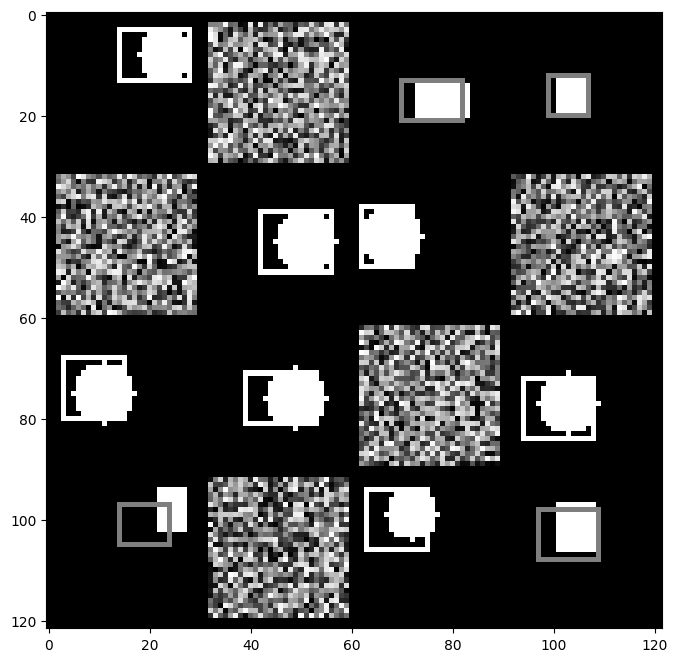

In [15]:
figures, _ = test_dataset[:16]
figures = figures.to(device)
to_show = []
for f in figures:
    fig = f.clone()
    l = model(fig.unsqueeze(0))[0].cpu()
    if l[0] > 0.5:
        draw_rect(fig, l[1:5], 1 if l[6] > 0.5 else 0.5)
    to_show.append(fig.cpu())

plt.figure(figsize=(8,8))
plt.imshow(np.transpose(vutils.make_grid(to_show, padding=2, normalize=True, nrow=4)
                        ,(1,2,0)))
plt.show()